In [57]:
import numpy as np
import math


class DistanceGenerator(object):
    def __init__(self, x, y, theta):
        self.x = x
        self.y = y
        self.theta = theta
        self.location = np.array([x, y])
        self.x_line_vertical = 500.0
        self.y_line_horizontal = 750.0
        self.min_distance = 0
        self.test_points = [[0, 0], [0, 0]]
        self.landmark_point = np.zeros(2)
        self.distance = 0

    def laser_output(self, x, y, theta):
        self.x = x
        self.y = y
        self.theta = theta
        self.location = np.array([x, y])
        test_points = self.valid_points()
        shape = np.shape(test_points)
        self.distance = np.zeros(int(shape[0]))

        for m, n in enumerate(test_points):
            self.distance[m] = self.distance_calc(n)
        self.min_distance = np.min(self.distance)
        return self.min_distance

    def direction_calc(self, X, nhat):
        rho = np.dot(X, nhat)/np.linalg.norm(X)
        value = np.round(rho, 0) + 1
        return value

    def distance_calc(self, point):
        distance = np.sqrt((point[0] - self.location[0])**2 + (point[1] - self.location[1])**2)
        return distance

    def valid_points(self):
        phi = self.theta + np.pi / 2
        nhat = np.array([np.cos(phi), np.sin(phi)])
        slope = np.tan(phi)
        y_int = self.y - slope*self.x
        direction_check = np.zeros(4)
        X = np.zeros((4, 2))

        if np.absolute(slope) < 1e-12:
            condition = 'slope is zero'
            slope = slope + 1
            alt_slope = 0
        else:
            condition = 'slope is not zero'
            alt_slope = slope

        # start with the y-int
        X[0] = np.array([0.0, y_int])
        # x-int
        X[1] = np.array([-y_int/slope, 0.0])
        # vertical line
        X[2] = np.array([self.x_line_vertical, alt_slope*self.x_line_vertical + y_int])
        # horizontal line
        X[3] = np.array([(self.y_line_horizontal-y_int)/slope, self.y_line_horizontal])
        bob = 2
        if condition == 'slope is zero':
            X = X[0::2]
            bob = 1
        elif np.absolute(slope) > 1e10:
            X = X[1::2]
            bob = 1
        X_relative = X - self.location

        i = 0
        while np.linalg.norm(direction_check) <= bob:
            direction_check[i] = self.direction_calc(X_relative[i], nhat)
            i += 1
        direction_index = [k for k, e in enumerate(direction_check) if e != 0]
        self.test_points = [X[direction_index[p]] for p, v in enumerate(direction_index)]
        return self.test_points

    def get_landmarks(self):
        landmark = np.argmin(self.distance)
        self.landmark_point = self.test_points[np.asscalar(landmark)]
        return self.landmark_point


class World:
    def __init__(self, Length, Width, radius, L):
        self.Length = Length
        self.Width = Width
        self.radius = radius
        self.L = L


class car_simulation(DistanceGenerator):
    def __init__(self, r, phi_1, phi_2, L, dt, total_time, x, y, theta):
        super(car_simulation, self).__init__(x, y, theta)
        self.x_i = x
        self.y_i = y
        self.theta_i = theta
        self.loops = np.round(total_time/dt, 0)
        self.r = r
        self.phi_1 = phi_1
        self.phi_2 = phi_2
        self.L = L
        self.sensor_output = np.zeros((int(self.loops), 4))
        self.dt = dt
        self.z = np.zeros((int(self.loops), 6))
        

    def get_simulation(self):
        # precompute the car simulation
        i = 0
        x_t_state = self.x_i
        y_t_state = self.y_i
        theta_t_state = self.theta_i
        bias_state = .05
        x = []
        y = []
        
        while i < self.loops:
            w_omega_t = np.random.normal(0, 0.0288)
            w_v_t = np.random.normal(0, 0.0288)
            omega_t_state = ((self.r*self.phi_1) - (self.r*self.phi_2))/self.L + w_omega_t
            v_t_state = ((self.r*self.phi_1) + (self.r*self.phi_2))/2 + w_v_t
            x_t_state = x_t_state + v_t_state*math.cos(theta_t_state + np.pi/2)*self.dt
            y_t_state = y_t_state + v_t_state*math.sin(theta_t_state + np.pi/2)*self.dt
            theta_t_state = (theta_t_state + 2 * np.pi) % (2 * np.pi) + omega_t_state*self.dt
            bias_state = bias_state
            #find_xy(x__state,y_t_state)
            x.append(x_t_state)
            y.append(y_t_state)
            self.z[i][:] = np.array([x_t_state, y_t_state, v_t_state,
                                     theta_t_state, omega_t_state, bias_state])
            i = i + 1
        return self.z,x,y
    
    def get_sensor_simulation(self):
        # precompute the sensor output
        i = 0
        while i < self.loops:
            distance_one = self.laser_output(self.z[i][0], self.z[i][1], self.z[i][3]) + np.random.normal(0, .04)
            distance_two = self.laser_output(self.z[i][0], self.z[i][1], self.z[i][3] + np.pi/2)\
                           + np.random.normal(0, .04)
            theta_t_measured = self.z[i][3] + np.random.normal(0, .001) + self.z[i][5]
            omega_t_measured = self.z[i][4] + np.random.normal(0, .001)
            self.sensor_output[i][:] = np.array([distance_one, distance_two, theta_t_measured, omega_t_measured])
            i = i + 1
        return self.sensor_output

def find_F_t(F_t,theta_t_hat, v_t_hat, dt): # good
    F_t[0][3] = -1 * v_t_hat * np.sin(theta_t_hat + np.pi/2) * dt
    F_t[1][3] = v_t_hat * np.cos(theta_t_hat + np.pi/2) * dt
    F_t[0][0], F_t[1][1], F_t[2][2], F_t[3][3], F_t[4][4], F_t[5][5] = 1, 1, 1, 1, 1, 1
    return F_t


def find_W_t(W_t,theta_t_hat, dt): # good
    W_t[0][0] = math.cos(theta_t_hat + np.pi/2) * dt
    W_t[1][0] = math.sin(theta_t_hat + np.pi/2) * dt
    W_t[3][1] = dt
    W_t[2][0], W_t[4][1] = 1, 1
    return W_t


def find_H_t(H_t,observation,z_bar,landmark_values): # good
    x_bar = z_bar[0]
    y_bar = z_bar[1]
    x_l1_bar = landmark_values[0][0]
    y_l1_bar = landmark_values[0][1]
    x_l2_bar = landmark_values[1][0]
    y_l2_bar = landmark_values[1][1]
    d1_bar = observation[0]
    d2_bar = observation[1]
    H_t[0][0] = (x_bar - x_l1_bar)/d1_bar
    H_t[0][1] = (y_bar - y_l1_bar)/d1_bar
    H_t[1][1] = (y_bar - y_l2_bar)/d2_bar
    H_t[1][0] = (x_bar - x_l2_bar)/d2_bar
    H_t[2][3], H_t[3][4] = 1, 1
    return H_t


class EKF(car_simulation):
    c1 = .1 # trust the measurement over the model
    c2 = .01
    c3 = 1
    c4 = 1
    c5 = 10
    c6 = 10

    def __init__(self, phi_1, phi_2, dt, L, r, total_time, x, y, theta):
        super(EKF, self).__init__(r, phi_1, phi_2, L, dt, total_time, x, y, theta)
        self.z_hat = np.zeros(6)
        self.z_hat[0] = x
        self.z_hat[1] = y
        self.z_hat[2] = ((r * phi_1) + (r * phi_2)) / 2
        self.z_hat[3] = theta
        self.z_hat[4] = ((r*phi_1) - (r*phi_2))/L
        self.z_hat[5] = .05
        self.z_bar = np.zeros(6)
        self.landmark_0 = 0
        self.landmark_1 = 0
        self.F_t = np.zeros((6, 6))
        self.W_t = np.zeros((6, 2))
        self.sigma_hat = np.zeros((6, 6))
        self.sigma_bar = np.zeros((6, 6))
        self.H_t = np.zeros((4, 6))
        self.observation_model = np.zeros(4)
        self.Q = np.diag(np.array([self.c1*np.random.normal(0, 0.0288), self.c2*np.random.normal(0, 0.0288)]))
        self.R = np.diag(np.array([self.c3*np.random.normal(0, 0.04), self.c4*np.random.normal(0, 0.04),
                                   self.c5*np.random.normal(0, .001), self.c6*np.random.normal(0, .001)]))
        self.error = 0
        
    def time_propagation_update(self):
        x_t_hat = self.z_hat[0]
        y_t_hat = self.z_hat[1]
        v_t_hat = self.z_hat[2]
        theta_t_hat = self.z_hat[3]
        omega_t_hat = self.z_hat[4]
        bias = self.z_hat[5]

        x_t_plus_one_bar = x_t_hat + v_t_hat*math.cos(theta_t_hat + np.pi/2)*self.dt
        y_t_plus_one_bar = y_t_hat + v_t_hat*math.sin(theta_t_hat + np.pi/2)*self.dt
        v_t_plus_one_bar = v_t_hat
        theta_t_plus_one_bar = (theta_t_hat + 2 * np.pi) % (2 * np.pi) + omega_t_hat*self.dt
        omega_t_plus_one_bar = omega_t_hat
        bias_plus_one_bar = bias

        self.z_bar[0] = x_t_plus_one_bar
        self.z_bar[1] = y_t_plus_one_bar
        self.z_bar[2] = v_t_plus_one_bar
        self.z_bar[3] = theta_t_plus_one_bar
        self.z_bar[4] = omega_t_plus_one_bar
        self.z_bar[5] = bias_plus_one_bar
        return self.z_bar

    def time_linearization(self):
        v_t_hat = self.z_hat[2]
        theta_t_hat = self.z_hat[3]
        self.F_t = find_F_t(self.F_t, theta_t_hat, v_t_hat, self.dt)
        self.W_t = find_W_t(self.W_t, theta_t_hat, self.dt)
        return self.F_t, self.W_t

    def covariance_update(self): # good
        sigma_t_plus_one_temp1 = np.dot(self.F_t, self.sigma_hat)
        sigma_t_plus_one_temp2 = np.dot(sigma_t_plus_one_temp1, self.F_t.transpose())
        sigma_t_plus_one_temp3 = np.dot(self.W_t, self.Q)
        sigma_t_plus_one_temp4 = np.dot(sigma_t_plus_one_temp3, self.W_t.transpose())
        self.sigma_bar = sigma_t_plus_one_temp2 + sigma_t_plus_one_temp4
        return self.sigma_bar

    def get_observation_model(self): # good
        x_bar = self.z_bar[0]
        #print 'location'
        #print x_bar
        y_bar = self.z_bar[1]
        #print y_bar
        theta_bar = self.z_bar[3]
        omega_bar = self.z_bar[4]
        bias_bar = self.z_bar[5]
        distance_one_bar = self.laser_output(x_bar, y_bar, theta_bar)
        #print 'distance one'
        #print distance_one_bar
        self.landmark_0 = self.get_landmarks()
        distance_two_bar = self.laser_output(x_bar, y_bar, theta_bar + np.pi / 2)
        #print distance_two_bar
        self.landmark_1 = self.get_landmarks()
        self.observation_model[0] = distance_one_bar + np.random.normal(0, .04)
        self.observation_model[1] = distance_two_bar + np.random.normal(0, .04)
        self.observation_model[2] = theta_bar + np.random.normal(0, .001) + bias_bar
        self.observation_model[3] = omega_bar + np.random.normal(0, .001)
        return self.observation_model

    def observation_linearization(self): # good
        landmark_values = [self.landmark_0, self.landmark_1]
        self.H_t = find_H_t(self.H_t, self.observation_model, self.z_bar, landmark_values)
        return self.H_t


    def kalman_gain_value(self): # good
        inner_temp1 = np.dot(self.H_t, self.sigma_bar)
        inner_temp2 = np.dot(inner_temp1, self.H_t.transpose())
        inner_temp3 = inner_temp2 + self.R
        inner_temp4 = np.linalg.inv(inner_temp3)
        outer_temp = np.dot(self.sigma_bar, self.H_t.transpose())
        self.kalman_gain = np.dot(outer_temp, inner_temp4)
        return self.kalman_gain

    def error_calculation(self, sensor_read):
        self.error = sensor_read - self.observation_model
        self.error[3] = self.error[3] % (2 * np.pi)
        if self.error[3] > np.pi:
            self.error[3] -= 2 * np.pi
        #print self.error
        return self.error
        
    def conditional_mean(self): # good last resort change the model to something linear
        temp_product = np.dot(self.kalman_gain, self.error)
        self.z_hat = self.z_bar + temp_product
        #print self.z_bar
        #print self.kalman_gain
        #print self.z_hat
        #print self.z_hat
        return self.z_hat

    def observation_update_covariance(self): # good
        inner_product1 = np.dot(self.kalman_gain, self.H_t)
        inner_product2 = np.dot(inner_product1, self.sigma_bar)
        self.sigma_hat = self.sigma_bar - inner_product2
        return self.sigma_hat




In [62]:

k = 0
input1 = -.6
input2 = .3
sim_time = 4 # the car travels at 20 mm per second
wheel_radius = 20
width = 500
height = 750
wheel_base = 85
time_step = .01
x_i = 300
y_i = 300
theta_i = 0
track = World(height, width, wheel_radius, wheel_base)
car = car_simulation(wheel_radius, input1, input2, wheel_base, time_step, sim_time, x_i, y_i, theta_i)
car_state,x,y = car.get_simulation()
car_sensor_readout = car.get_sensor_simulation()
estimator = EKF(input1, input2, time_step, wheel_base, wheel_radius, sim_time, 250, 250, 0)
z_hat_list = np.zeros((1, 6))

x1 = []
y1 = []
while k < car.loops:
    z_bar = estimator.time_propagation_update()
        #print z_bar
    F_t, W_t = estimator.time_linearization()
    sigma_bar = estimator.covariance_update()
    h_z = estimator.get_observation_model()
        #print h_z
    H_t = estimator.observation_linearization()
    k_gain = estimator.kalman_gain_value()
    error = estimator.error_calculation(car_sensor_readout[k])
    z_hat = np.array([estimator.conditional_mean()])
    #print(z_hat)
    x1.append(z_hat[0][0])
    y1.append(z_hat[0][1])
    z_hat_list = np.concatenate((z_hat_list, z_hat), axis = 0)
    sigma_hat = estimator.observation_update_covariance()
    #print(sigma_hat)
    
    k = k + 1
    #print car_sensor_readout
    #print car_state
z_hat_final = z_hat_list[1:]
print (car_state)
print (z_hat_final)


[[ 3.00000000e+02  2.99969639e+02 -3.03609236e+00 -2.07354810e-03
  -2.07354810e-01  5.00000000e-02]
 [ 2.99999939e+02  2.99940050e+02 -2.95891323e+00  6.27891366e+00
  -2.19809581e-01  5.00000000e-02]
 [ 2.99999810e+02  2.99909836e+02 -3.02139441e+00  6.27670121e+00
  -2.21245411e-01  5.00000000e-02]
 ...
 [ 2.95289015e+02  2.89422196e+02 -2.97850245e+00  5.43643342e+00
  -2.76351493e-01  5.00000000e-02]
 [ 2.95266594e+02  2.89402371e+02 -2.99286468e+00  5.43411156e+00
  -2.32186436e-01  5.00000000e-02]
 [ 2.95244451e+02  2.89382882e+02 -2.94972361e+00  5.43214045e+00
  -1.97110865e-01  5.00000000e-02]]
[[ 2.50000000e+02  2.49970195e+02 -2.98052015e+00 -2.14438457e-03
  -2.14438457e-01  5.00000000e-02]
 [ 2.49999939e+02  2.49940779e+02 -2.94156036e+00  6.27900827e+00
  -2.03265588e-01  5.00000000e-02]
 [ 2.49999805e+02  2.49911950e+02 -2.88297017e+00  6.27668382e+00
  -2.32444773e-01  5.00000000e-02]
 ...
 [ 2.48432206e+02  2.48431174e+02 -4.69252130e+01 -8.48626235e-02
  -1.06953733e

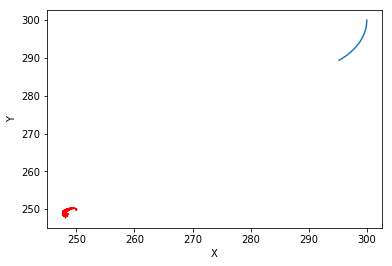

In [63]:
import matplotlib.pyplot as plt
plt.plot(x,y, label = 'robot')
plt.plot(x1,y1,linestyle = 'dashed', color = 'r',label= 'estimate')
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [49]:
print(sigma_hat)

[[-1.95037130e-05 -2.88986612e-05 -3.53669480e-03 -2.52587258e-08
  -2.52587258e-06  0.00000000e+00]
 [-2.88986612e-05 -6.80876414e-05 -7.61650694e-03  2.77065098e-08
   2.77065098e-06  0.00000000e+00]
 [-3.53669480e-03 -7.61650694e-03 -8.65764440e-01  2.27913915e-08
   2.27913915e-06  0.00000000e+00]
 [-2.52587258e-08  2.77065098e-08  2.27913915e-08 -1.92134543e-07
  -1.92134543e-05  0.00000000e+00]
 [-2.52587258e-06  2.77065098e-06  2.27913915e-06 -1.92134543e-05
  -1.92134543e-03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
